In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np, h5py, pyqtgraph as pg, matplotlib.pyplot as plt, concurrent.futures, exfel, os
from multiprocessing import cpu_count, Pool
from functools import partial
from scipy.ndimage.filters import median_filter
from scipy.optimize import curve_fit
from scipy import constants

In [2]:
basepath = "/gpfs/exfel/u/scratch/MID/201802/p002200/cheetah/hdf5/r{0:04d}-{2:s}/XFEL-r{0:04d}-c{1:02d}.cxi"
outpath = "hdf5/r{0:04d}-processed/XFEL-r{0:04d}-c{1:02d}.cxi"
userpath = "cheetah/XFEL-r{0:04d}-c{1:02d}.cxi"
datapath = "entry_1/instrument_1/detector_1/detector_corrected/data"
trainpath = "/instrument/trainID"
pulsepath = "/instrument/pulseID"
data_roi = [(slice(6790, 7090), slice(55)), (slice(7300, 7600), slice(None)), (slice(7810, 8110), slice(90, -1))]
bg_roi = (slice(5000), slice(None))
pupil_roi = (slice(750, 1040), slice(780, 1090))
plane_roi = (slice(830, 950), slice(897, 960))
cnum = 0; tag = 'data'; ext = 'cxi'
gain = 68.8
gain_verge = 6000
transmission = 0.047 * 0.58 * 0.65
wavelength = 1.37 * 1e-7

In [36]:
raw_path = 'raw/RAW-R0283-AGIPD{:02d}-S00000.h5'
raw_data = exfel.RawModuleJoined(module_id=14, file_path=raw_path)
data = raw_data.get_ordered_data(pids=4)

In [3]:
import pickle

data = pickle.load(open('raw/data.pickle', 'rb'))

In [4]:
dark_calib_path = 'calib/Cheetah-AGIPD{:02d}-calib.h5'
dark_calib = exfel.DarkCalib(dark_calib_path.format(14))
calib_data = exfel.CalibData(data, dark_calib)

In [5]:
hg_data = calib_data.hg_data(images=(0, 10))

In [6]:
hg_data.calibrate_gui(roi=(-100, 200))

(-0.5, 113.50000000000001)

In [ ]:
%matplotlib inline
plt.hist(hg_data.data[2, 0:100].ravel(), 100, log=True)
plt.show()

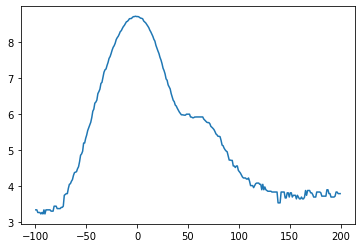

In [51]:
%matplotlib inline
hist, adus = hg_data.histogram(roi=(-100, 200))
plt.plot(adus, median_filter(np.log(hist), 5))
plt.show()

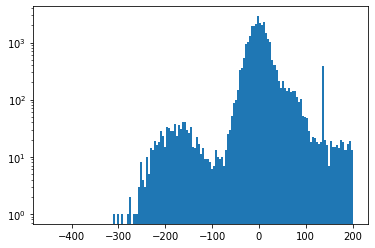

In [12]:
%matplotlib inline
plt.hist(hg_data.data[0].ravel(), 150, range=(-450, 200), log=True)
plt.show()

In [ ]:
def gauss(xs, A, mu, sigma):
    return A * np.exp(-(xs - mu)**2 / 2 / sigma**2)

def r_to_slice(roi, roi0):
    return slice(roi[0] - roi0[0], roi[1] - roi0[0])

def argmax_in_roi(vals, args, roi, roi0):
    return args[vals[r_to_slice(roi, roi0)].argmax() + roi[0] - roi0[0]]

def fit_gauss(data, roi=(-50, 200), roi1=(-15, 30), roi2=(50, 100), p10=[10, 15]):
    hist, bin_edges = np.histogram(data.ravel(), roi[1] - roi[0], range=roi)
    hist[abs(roi[0])] = (hist[abs(roi[0]) - 1] + hist[abs(roi[0]) + 1]) / 2
    hlog, xs = np.log(hist) - np.log(hist).min(), (bin_edges[1:] + bin_edges[:-1]) / 2
    mu1 = argmax_in_roi(hlog, xs, roi1, roi)
    p1, cov1 = curve_fit(lambda x, A, sigma: gauss(x, A, mu1, sigma), xs[r_to_slice(roi1, roi)], hlog[r_to_slice(roi1, roi)], p0=p10)
    mu2 = argmax_in_roi(hlog - gauss(xs, p1[0], mu1, p1[1]), xs, roi2, roi)
    return mu1, mu2, p1[0], p1[1], cov1

In [5]:
import sys, time
from IPython.display import clear_output

def real_time_stdout(ar, dt=1, truncate=1000):
    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        for eid, stdout in zip(ar._targets, ar.stdout):
            if stdout:
                print("[stdout {0:2d}]: {1}".format(eid, stdout[-truncate:]))
        sys.stdout.flush()
        time.sleep(dt)

In [3]:
from ipyparallel import Client, error
cluster = Client(profile="mpi")
cluster.block = True
dview = cluster[:]
dview.activate()

%pxconfig --noblock
%px import xfl_dp
%px scan = xfl_dp.XFLData(218, 0, 'data', online=False)
%px data, tids, pids = scan.data_mpi()

<AsyncResult: execute>

In [2]:
import pickle

raw = pickle.load(open('raw/test_file', 'rb'))

In [39]:
out_file.close()

In [40]:
out_file = h5py.File('raw/test_file.h5', 'w')
def create_h5(out_file, data_dict):
    for key, val in data_dict.items():
        if isinstance(val, dict):
            group = out_file.create_group(key)
            create_h5(group, val)
        elif isinstance(val, list) and isinstance(val[0], str):
            out_file.create_dataset(key, data=np.array(val, dtype=h5py.string_dtype(encoding='utf-8')))
        else:
            out_file.create_dataset(key, data=val)
            
create_h5(out_file, raw)
out_file.close()

# Bull's Eye Movie

In [56]:
beyeraw = [h5py.File(outpath.format(rnum, 0), 'r')['data/data'][:] for rnum in range(215, 218)]
whitefield = h5py.File(outpath.format(218, 0), 'r')['data/data'][:]
tids215 = h5py.File(outpath.format(215, 0), 'r')['data/trainID'][:]

In [28]:
beyefilt = np.array([median_filter(frame, 3) for frame in bullseye[0] / (1 + np.mean(whitefield, axis=0))])[:, 7:-7, 7:-7]

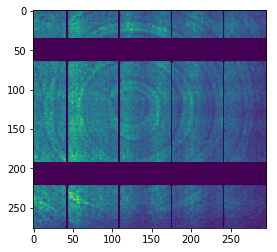

In [35]:
%matplotlib inline
plt.imshow(beyefilt[0], vmin=0, vmax=1.5)
plt.show()

In [59]:
%%capture

from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow([[]], vmin=0, vmax=1.5, cmap='viridis', extent=[0, beyefilt.shape[2], 0, beyefilt.shape[1]])

In [64]:
def init():
    im.set_data([[]])
    return im,

def animatebeye(i):
    ax.set_title("Train ID = {:d}".format(int(tids215[i])))
    im.set_data(beyefilt[i])
    return im,

beyemov = animation.FuncAnimation(fig, animatebeye, init_func=init, interval=500, frames=20, blit=True)
# beyemov.save('movies/bullseye.mp4', extra_args=['-vcodec', 'libx264'])
HTML(beyemov.to_html5_video())

# Photon correction

In [ ]:
raw_file = h5py.File('hdf5/r0221_raw.h5', 'r')
data = raw_file['data/data'][:]
gain = raw_file['data/gain'][:]

In [ ]:
calib = h5py.File('cheetah/calib/Cheetah-calib-pupil.h5', 'r')
offsets = calib['AnalogOffset']
gainlevels = calib['DigitalGainLevel']

In [ ]:
calib_data = np.where(gain < gainlevels[1, 1], (data - offsets[0, 1]) / 68.8, (data - offsets[1, 1]) / 1.376)
hist, edges = np.histogram(calib_data.ravel(), 200, range=(-50, 15000))
hist[50] = (hist[49] + hist[51]) / 2
adus = (edges[:-1] + edges[1:]) / 2

In [ ]:
%gui qt
pg.image(calib_data)

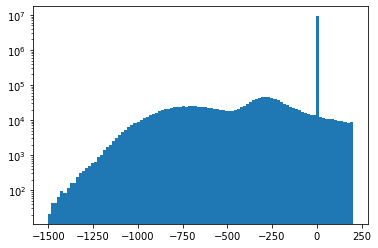

In [61]:
%matplotlib inline
plt.hist((data - offsets[0, 1])[gain < 6000], 100, range=(-1500, 200), log=True)
plt.show()

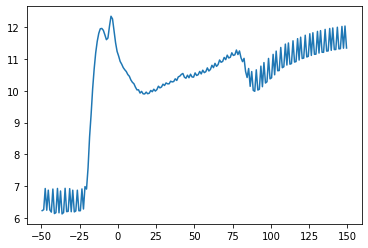

In [66]:
%matplotlib inline
plt.plot(adus, np.log(hist))
plt.show()

In [4]:
f283 = h5py.File(outpath.format(283, 0), 'r')
datalist_283 = []
for key in f283['data/data']:
    datalist_283.append(f283['data/data/' + key][:])

NameError: name 'outpath' is not defined

In [14]:
roi, roi1, roi2 = (-50, 200), (-15, 30), (50, 100)
p10, p20 = [10, 15], [4, 5]
hist, bin_edges = np.histogram(datalist283[0].ravel(), roi[1] - roi[0], range=roi)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
hist[abs(roi[0])] = (hist[abs(roi[0]) - 1] + hist[abs(roi[0]) + 1]) / 2
hist = np.log(hist) - np.log(hist).min()
mu1 = argmax_in_roi(hist, bin_centres, roi1, roi)
p1, cov1 = curve_fit(lambda x, A, sigma: gauss(x, A, mu1, sigma), bin_centres[r_to_slice(roi1, roi)], hist[r_to_slice(roi1, roi)], p0=p10)
mu2 = argmax_in_roi(hist - gauss(bin_centres, p1[0], mu1, p1[1]), bin_centres, roi2, roi)
p2, cov2 = curve_fit(lambda x, A, sigma: gauss(x, A, mu2, sigma), bin_centres[r_to_slice(roi2, roi)], (hist - gauss(bin_centres, p1[0], mu1, p1[1]))[r_to_slice(roi2, roi)], p0=p20)
print(mu1, mu2, mu2 - mu1)
print(fit_gauss(datalist_283[0]))

5.5 75.5 70.0
(5.5, 75.5, 3.207681592818699, 26.752723477496087, array([[ 2.30103494e-05, -4.76381259e-04],
       [-4.76381259e-04,  2.02547648e-02]]))


In [15]:
np.save('hist', hist)
np.save('adus', bin_centres)

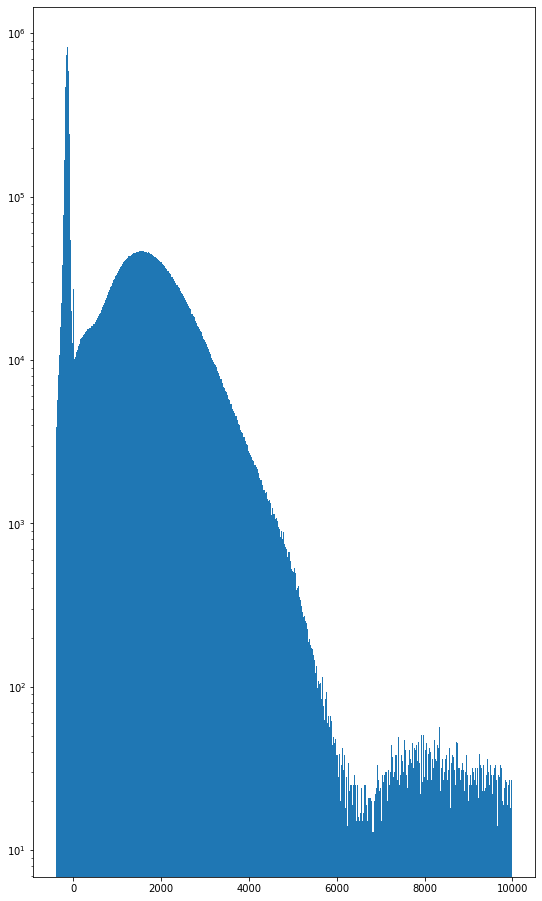

In [9]:
%matplotlib inline
plt.figure(figsize=(9, 16))
plt.hist(data.ravel(), 1000, range=(-400, 10000), log=True)
plt.show()

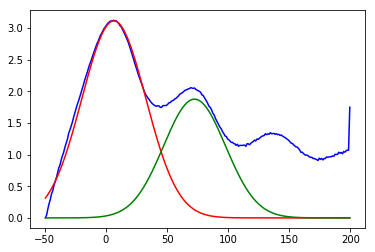

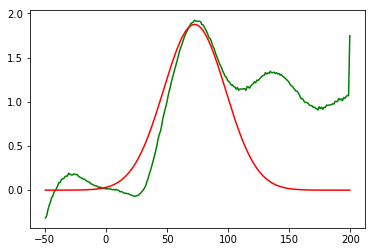

In [102]:
%matplotlib inline
plt.figure()
plt.plot(bin_centres, hist, 'b', bin_centres, gauss(bin_centres, p1[0], mu1, p1[1]), 'r', bin_centres, gauss(bin_centres, p2[0], mu2, p2[1]), 'g')
plt.figure()
plt.plot(bin_centres, hist - gauss(bin_centres, p1[0], mu1, p1[1]), 'g', bin_centres, gauss(bin_centres, p2[0], mu2, p2[1]), 'r')
plt.show()

In [97]:
fit_data = np.array([fit_gauss(data) for data in datalist_283])
gain = np.mean(fit_data[:, 1] - fit_data[:, 0])
gain

68.8

# Run 283 photon numbers

In [48]:
pids = np.unique(h5py.File(outpath.format(283, cnum, ext), 'r')['data/pulseID'][:])
xfl_data = xfl_dp.PupilData(283, 0, tag, online=False)
datalist_283, tidslist_283 = xfl_data.pids_data(pids)

In [13]:
xfl_data2 = xfl_dp.PupilData(283, 1, tag, online=False)
datalist2, tidslist2 = xfl_data2.pids_data(pids)

In [54]:
pupil_sums = [data.sum(axis=(1, 2)) / gain for data in datalist_283]
pupil_avs = np.array([p_sum.mean() for p_sum in pupil_sums])
pupil_mean = np.array([np.mean(data, axis=0) for data in datalist_283])

In [26]:
print('{:.3e}'.format(pupil_avs.sum() / transmission(0.08)), 
      '{:.3e}'.format(pupil_avs2.sum() / transmission(0.08)))

5.469e+09 5.455e+09


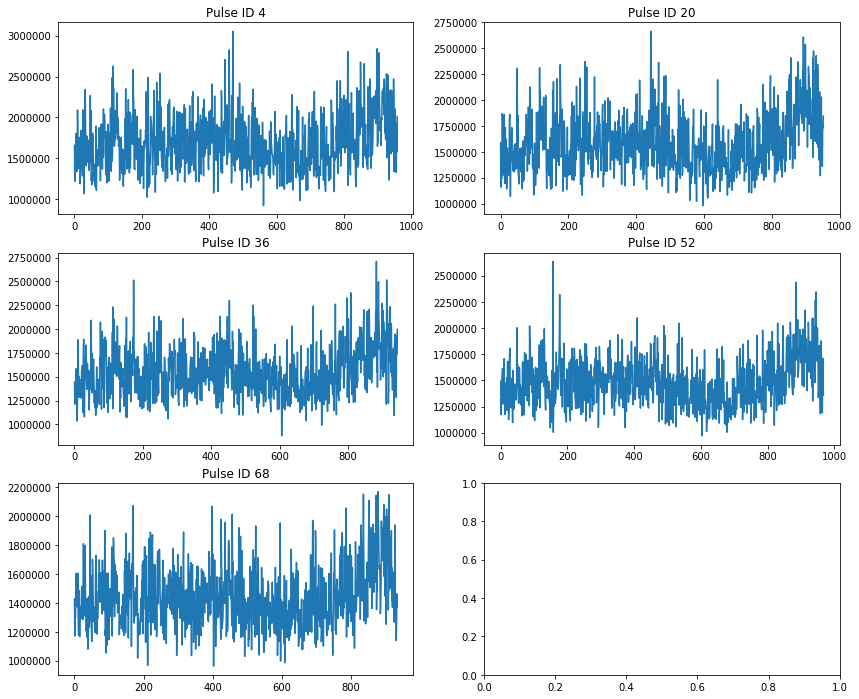

In [29]:
%matplotlib inline
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
for counter, pupil_sum in enumerate(pupil_sums):
    axes[counter // 2, counter % 2].plot(pupil_sum)
    axes[counter // 2, counter % 2].set_title('Pulse ID {:d}'.format(pids[counter]))
plt.show()

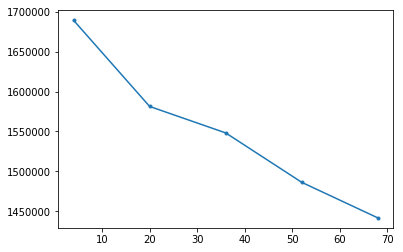

In [199]:
%matplotlib inline
plt.plot(pids, pupil_avs, marker='.')
plt.show()

In [203]:
pupil_sums_295 = [data.sum(axis=(1, 2)) / gain for data in datalist_295]
pupil_avs_295 = np.array([p_sum.mean() for p_sum in pupil_sums_295])

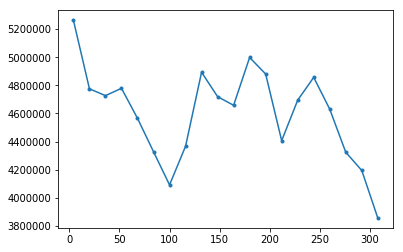

In [205]:
%matplotlib inline
plt.plot(pids_295, pupil_avs_295, marker='.')
plt.show()

# Correlation Analysis

In [4]:
pids = np.unique(h5py.File(userpath.format(283, cnum), 'r')[pulsepath][:])
xfl_data = xfl_dp.PupilData(283, 0, tag, online=False)
datalist_283, tidslist_283 = xfl_data.pids_data(pids)

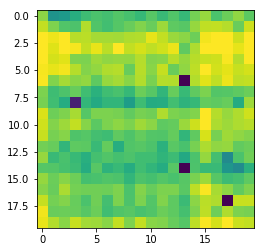

In [247]:
%matplotlib inline
roi = (250, 270)
plt.imshow(pupildata[222][0, 170:190, roi[0]:roi[1]], vmin=0, vmax=50000)

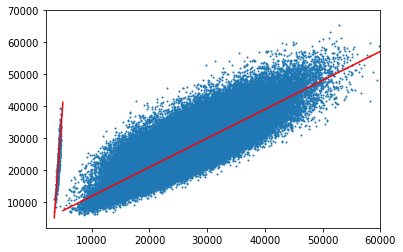

In [261]:
%matplotlib inline
fig, axes = plt.subplots(1, 1)
roiv, roih, spacing = slice(170, 190), np.array([250, 270]), 50
xs, ys = pupildata[222][:, roiv, slice(*roih)].ravel(), pupildata[222][:, roiv, slice(*(roih - spacing))].ravel()
fline = lambda x, a, b: x * a + b
pl1, covl1 = curve_fit(fline, xs[xs > 10000], ys[xs > 10000])
pl2, covl2 = curve_fit(fline, xs[(xs > 3500) & (xs < 5000)], ys[(xs > 3500) & (xs < 5000)])
axes.scatter(xs, ys, s=1)
axes.plot(np.linspace(5000, 60000, 10), fline(np.linspace(5000, 60000, 10), pl1[0], pl1[1]), 'r')
axes.plot(np.linspace(3500, 5000, 10), fline(np.linspace(3500, 5000, 10), pl2[0], pl2[1]), 'r')
axes.set_xlim([2000, 60000])
axes.set_ylim([2000, 70000])
plt.show()

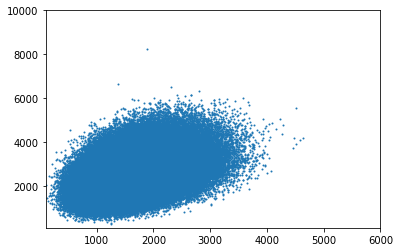

In [183]:
%matplotlib inline
fig, axes = plt.subplots(1, 1)
axes.scatter(datalist_283[0][:, 170:190, 250:270].ravel(), datalist_283[0][:, 170:190, 200:220].ravel(), s=1)
axes.set_xlim([100, 6000])
axes.set_ylim([100, 10000])
plt.show()

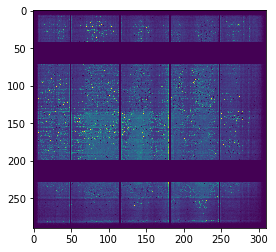

In [187]:
%matplotlib inline
plt.imshow(datalist[0][0], vmin=0, vmax=30000)

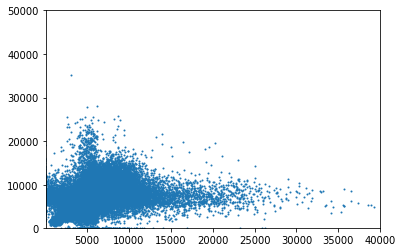

In [196]:
%matplotlib inline
fig, axes = plt.subplots(1, 1)
spacing = 50
axes.scatter(datalist_295[0][:, 170:190, 250:270].ravel(), datalist_295[0][:, 170:190, 250-spacing:270-spacing].ravel(), s=1)
axes.set_xlim([100, 40000])
axes.set_ylim([100, 50000])
plt.show()

# Raw data analysis

In [3]:
f221raw = h5py.File('raw/r0221_raw.h5', 'r') 
adus = f221raw['data/ADU'][:]
gains = f221raw['data/DigitalGains'][:]

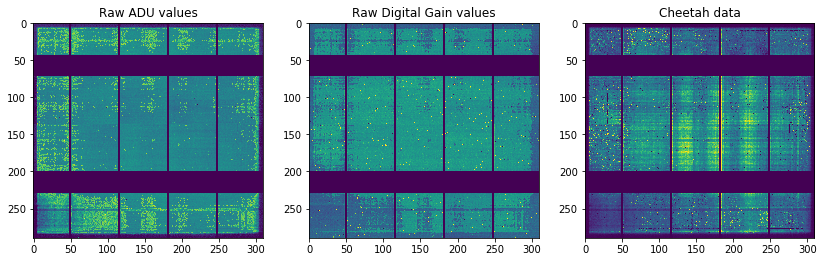

In [649]:
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
axes[0].imshow(adus[0], vmin=4000, vmax=12000)
axes[0].set_title('Raw ADU values')
axes[1].imshow(gains[0], vmin=4000, vmax=10000)
axes[1].set_title('Raw Digital Gain values')
axes[2].imshow(pupildata[221][0], vmin=0, vmax=20000)
axes[2].set_title('Cheetah data')
plt.show()

In [4]:
calib = h5py.File('cheetah/calib/Cheetah-calib-pupil.h5', 'r')
diggains = calib['DigitalGainLevel']
offsets = calib['AnalogOffset']
badpixels = calib['Badpixel']
gainmode = np.array([frame > diggains[1, 1] for frame in gains], dtype=int)
highgains = np.where((gainmode == 0) & (badpixels[0, 1] == 0), adus - offsets[0, 1], 0)
highgains[highgains < 0] = 0
midgains = np.where((gainmode == 1) & (badpixels[1, 1] == 0), adus - offsets[1, 1], 0)
midgains[midgains < 0] = 0

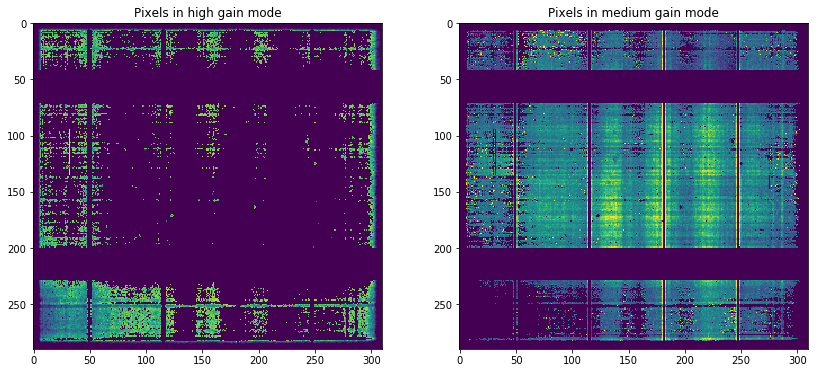

In [889]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(highgains[0], vmin=0, vmax=6800)
axes[0].set_title('Pixels in high gain mode')
axes[1].imshow(midgains[0], vmin=0, vmax=500)
axes[1].set_title('Pixels in medium gain mode')
plt.show()

In [890]:
corradus = highgains + 29 * midgains
totals = np.sum(corradus, axis=(1, 2)) / np.mean(np.sum(corradus, axis=(1, 2)))
highgains = np.array([frame / total for frame, total in zip(highgains, totals)])
midgains = np.array([frame / total for frame, total in zip(midgains, totals)])

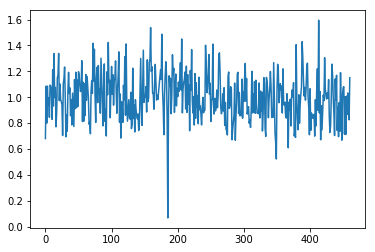

In [891]:
%matplotlib inline
plt.plot(totals)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


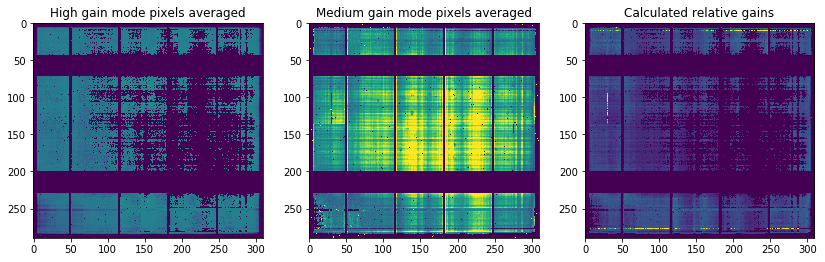

In [9]:
%matplotlib inline
htotals = np.sum(np.array(highgains != 0, dtype=int), axis=0)
avhgains = np.where(htotals != 0, highgains.sum(axis=0) / htotals, 0)
mtotals = np.sum(np.array(midgains != 0, dtype=int), axis=0)
avmgains = np.where(mtotals != 0, midgains.sum(axis=0) / mtotals, 0)
relgains = np.where((avhgains != 0) & (avmgains != 0), avhgains / avmgains, 0)
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
axes[0].imshow(avhgains, vmin=0, vmax=12000)
axes[0].set_title('High gain mode pixels averaged')
axes[1].imshow(avmgains, vmin=0, vmax=500)
axes[1].set_title('Medium gain mode pixels averaged')
axes[2].imshow(relgains, vmin=0, vmax=100)
axes[2].set_title('Calculated relative gains')
plt.show()

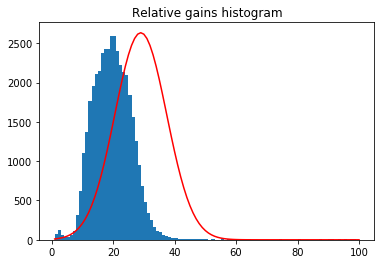

29.000000000000004 8.421526196088289


In [10]:
%matplotlib inline
hist, bin_edges = np.histogram(relgains.ravel(), 100, range=(0.5, 100.5))
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
p, cov = curve_fit(lambda x, mu, sigma: gauss(x, hist.max(), mu, sigma), bin_centres[0:60], hist[0:60], bounds=([29, 0], [31, 10]))
plt.hist(relgains.ravel(), 99, range=(1, 100), log=False)
plt.plot(bin_centres, gauss(bin_centres, hist.max(), p[0], p[1]), 'r')
plt.title('Relative gains histogram')
plt.show()
print(p[0], p[1])

# Point Spread Function

In [8]:
wavefronts = {'W190305C_XS04': np.loadtxt('wavefronts/export_251_sr.txt'),
              'W190315C_XL03': np.loadtxt('wavefronts/export_266_sr.txt')}

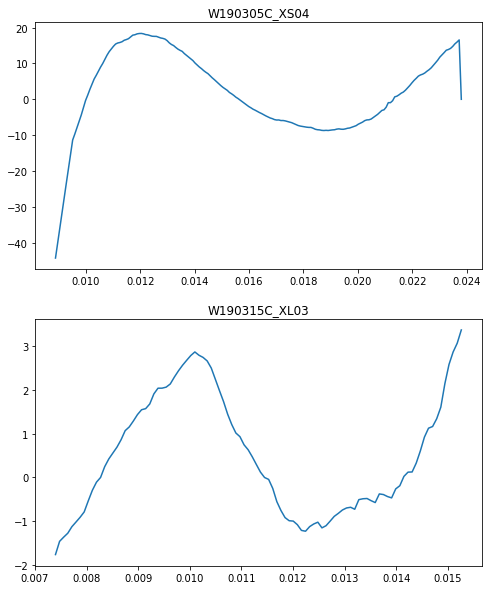

In [5]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
for counter, (name, wavefront) in enumerate(wavefronts.items()):
    axes[counter].plot(wavefront[:, 0], wavefront[:, 1])
    axes[counter].set_title(name)
plt.show()

In [9]:
pupil = np.mean(pupildata[222][:, 7:-7, 7:-7], axis=0)
pupil[pupil < 0] = 0
pupil = np.sqrt(pupil)
phase = np.multiply.outer(wavefronts['W190315C_XL03'], wavefronts['W190315C_XL03'])

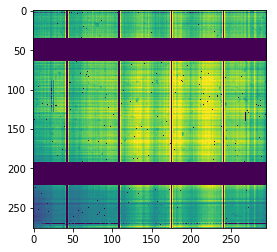

In [9]:
%matplotlib inline
plt.imshow(pupil, vmin=0, vmax=200)
plt.show()

In [10]:
dist = 4000
dthetas = 2 * np.array([0.0045, 0.0051])
dthetas2 = np.array(pupil.shape) * 0.2 / dist
fitpars = np.polyfit(x=wavefronts['W190315C_XL03'][:, 0], y=wavefronts['W190315C_XL03'][:, 1], deg=3)
thmax, thmin = wavefronts['W190315C_XL03'][:, 0].max(), wavefronts['W190315C_XL03'][:, 0].min()
thminx, thmaxx = (thmax * (1 + dthetas[0] / (thmax - thmin)) / 2 + thmin * (1 - dthetas[0] / (thmax - thmin)) / 2,
                  thmax * (1 - dthetas[0] / (thmax - thmin)) / 2 + thmin * (1 + dthetas[0] / (thmax - thmin)) / 2)
thminy, thmaxy = (thmax * (1 + dthetas[1] / (thmax - thmin)) / 2 + thmin * (1 - dthetas[1] / (thmax - thmin)) / 2,
                  thmax * (1 - dthetas[1] / (thmax - thmin)) / 2 + thmin * (1 + dthetas[1] / (thmax - thmin)) / 2)
thx, thy = (np.linspace(thminx, thmaxx, num=pupil.shape[0], endpoint=True),
            np.linspace(thminy, thmaxy, num=pupil.shape[1], endpoint=True))
phasex, phasey = np.polyval(p=fitpars, x=thx), np.polyval(p=fitpars, x=thy)

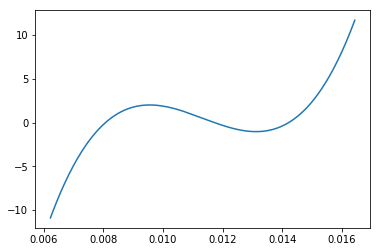

In [11]:
%matplotlib inline
plt.plot(thy, phasey)
plt.show()

In [11]:
u = pupil * np.exp(1j * np.add.outer(phasex, phasey))

In [12]:
import numba as nb
from math import cos, sin, pi

@nb.njit(nb.complex128[:, :](nb.complex128[:, :], nb.int64, nb.int64))
def psf(u, a, b):
    c, d = u.shape
    u = np.ascontiguousarray(u)
    out = np.zeros((a, b), dtype=np.complex128)
    for i in range(a):
        for j in range(b):
            for k in range(c):
                for l in range(d):
                    _ph = 2 * pi / wavelength / dist * 0.2e-6 * ((i - a / 2) * k + (j - b / 2) * l)
                    out[i, j] += u[k, l] * (cos(_ph) + 1j * sin(_ph))
    return out

@nb.njit(nb.complex128[:, :, :](nb.complex128[:, :, :], nb.int64, nb.int64))
def psfs(u, a, b):
    c, d, e = u.shape
    u = np.ascontiguousarray(u)
    out = np.zeros((a, b, c), dtype=np.complex128)
    for i in range(a):
        for j in range(b):
            for k in range(c):
                for l in range(d):
                    for m in range(e):
                        _ph = 2 * pi / wavelength / dist * 0.2e-6 * ((i - a / 2) * l + (j - b / 2) * m)
                        out[i, j, k] += u[k, l, m] * (cos(_ph) + 1j * sin(_ph))
    return out

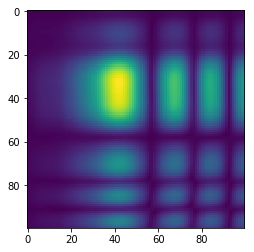

In [14]:
%matplotlib inline
psf1 = np.abs(psf(u, 100, 100))
plt.imshow(psf1)
plt.show()

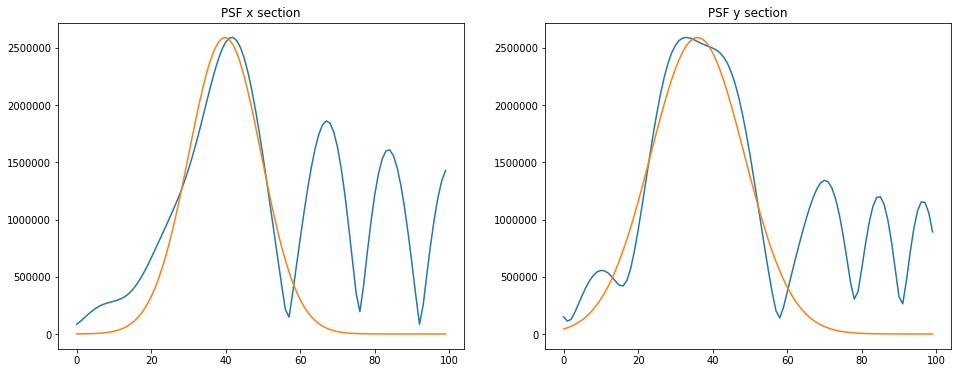

26.208869241708047


In [15]:
%matplotlib inline
psfx = psf1.max(axis=0)
psfy = psf1.max(axis=1)
px, covx = curve_fit(lambda x, mu, sigma: gauss(x, psfx.max(), mu, sigma), np.arange(100)[20:60], psfx[20:60], bounds=([30, 5], [60, 35]))
py, covy = curve_fit(lambda y, mu, sigma: gauss(y, psfy.max(), mu, sigma), np.arange(100)[20:60], psfy[20:60], bounds=([30, 5], [60, 35]))
beamsize = (px[1] + py[1]) * np.sqrt(2 * np.log(2))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(psfx)
axes[0].plot(np.arange(100), gauss(np.arange(100), psfx.max(), px[0], px[1]))
axes[0].set_title('PSF x section')
axes[1].plot(psfy)
axes[1].plot(np.arange(100), gauss(np.arange(100), psfy.max(), py[0], py[1]))
axes[1].set_title('PSF y section')
plt.show()
print(beamsize)

In [70]:
coeffs = np.linspace(0, 1, num=50, endpoint=True)
phxlist = np.multiply.outer(coeffs, np.polyval(x=thx, p=fitpars))
phylist = np.multiply.outer(coeffs, np.polyval(x=thy, p=fitpars))
us = pupil * np.exp(1j * (phxlist[:, :, np.newaxis] + phylist[:, np.newaxis, :]))
worker = partial(psf, a=100, b=100)
with concurrent.futures.ProcessPoolExecutor() as executor:
    psfs = np.array([psf for psf in executor.map(worker, us)])

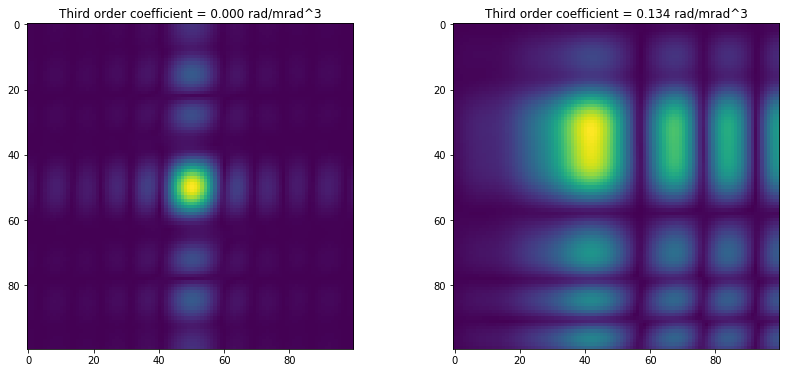

In [71]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(np.abs(psfs[0]))
axes[0].set_title('Third order coefficient = {:.3f} rad/mrad^3'.format(coeffs[0] * fitpars[0] * 1e-9))
axes[1].imshow(np.abs(psfs[-1]))
axes[1].set_title('Third order coefficient = {:.3f} rad/mrad^3'.format(coeffs[-1] * fitpars[0] * 1e-9))
plt.show()

In [91]:
beamsizes = []
for psfx, psfy in zip(np.abs(psfs).max(axis=1), np.abs(psfs).max(axis=2)):
    px, covx = curve_fit(lambda x, mu, sigma: gauss(x, psfx.max(), mu, sigma), np.arange(100)[20:60], psfx[20:60], bounds=([30, 5], [60, 35]))
    py, covy = curve_fit(lambda y, mu, sigma: gauss(y, psfy.max(), mu, sigma), np.arange(100)[20:60], psfy[20:60], bounds=([20, 5], [60, 35]))
    beamsizes.append((px[1] + py[1]) * np.sqrt(2 * np.log(2)))

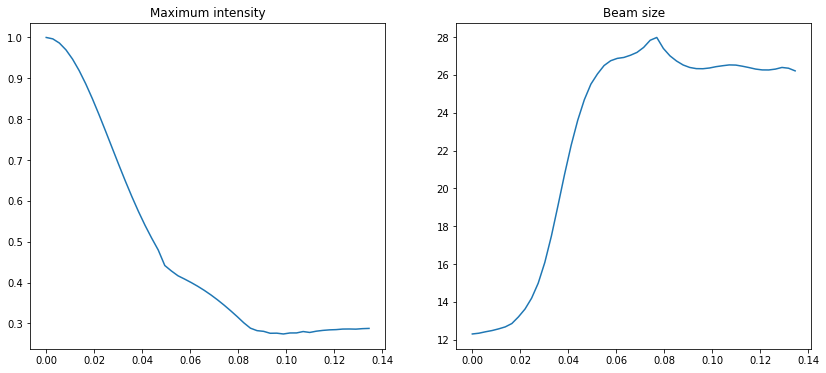

In [94]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(fitpars[0] * 1e-9 * coeffs, np.abs(psfs.max(axis=(1, 2))) / np.abs(psfs.max()))
axes[0].set_title('Maximum intensity')
axes[1].plot(fitpars[0] * 1e-9 * coeffs, np.array(beamsizes))
axes[1].set_title('Beam size')
plt.show()

# Transmission series

In [5]:
series = {218: 0.07, 219: 0.279, 220: 0.279, 221: 0.46, 222: 0.92}
energies = {218: 1.14, 219: 1.14, 220: 1.12, 221: 1.1, 222: 1.1}
pupildata = dict([(key, h5py.File(outpath.format(key, 0, ), 'r')['data/data'][:]) for key in series])
pupildatanew = dict([(key, h5py.File(outpath.format(key, 1), 'r')['data/data'][:]) for key in series])

In [6]:
outpows = dict([(key, data.sum(axis=(1, 2)) / gain) for key, data in pupildata.items()])
incpows = dict([(key, outpow / transmission) for key, outpow in outpows.items()])
avoutpows = dict([(key, np.mean(outpow).astype(np.int64)) for key, outpow in outpows.items()])
avincpows = dict([(key, np.mean(incpow).astype(np.int64)) for key, incpow in incpows.items()])

In [7]:
outpowsnew = dict([(key, data.sum(axis=(1, 2)) / gain) for key, data in pupildatanew.items()])
incpowsnew = dict([(key, outpow / transmission) for key, outpow in outpowsnew.items()])
avoutpowsnew = dict([(key, np.mean(outpow).astype(np.int64)) for key, outpow in outpowsnew.items()])
avincpowsnew = dict([(key, np.mean(incpow).astype(np.int64)) for key, incpow in incpowsnew.items()])

In [ ]:
for outpow in avoutpowsnew

In [16]:
phenergy = 9000 * constants.e
pdur = 50 * 1e-15
beamarea = (beamsize * 1e-7)**2
focints = dict([(key, incpow * phenergy / pdur / beamarea) for key, incpow in avincpows.items()])
focintsnew = dict([(key, incpow * phenergy / pdur / beamarea) for key, incpow in avincpowsnew.items()])

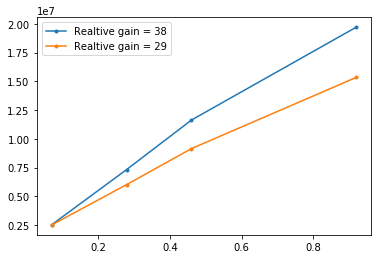

In [17]:
%matplotlib inline
plt.plot(np.sort(np.array(list(series.values())))[[0, 1, 3, 4]],
         np.sort(np.array(list(avoutpows.values())))[[0, 1, 3, 4]], marker = '.', label='Realtive gain = 38')
plt.plot(np.sort(np.array(list(series.values())))[[0, 1, 3, 4]],
         np.sort(np.array(list(avoutpowsnew.values())))[[0, 1, 3, 4]], marker = '.', label='Realtive gain = 29')
plt.legend()
plt.show()

In [31]:
w = 2 * pi * constants.c / wavelength / 1e-3
E = w * constants.m_e * constants.c / constants.e
ENe = 1 / (4 * pi * constants.epsilon_0) * 10 * constants.e / (130 * 1e-12)**2
INe = constants.c * constants.epsilon_0 / 2 * ENe**2 / 1e4

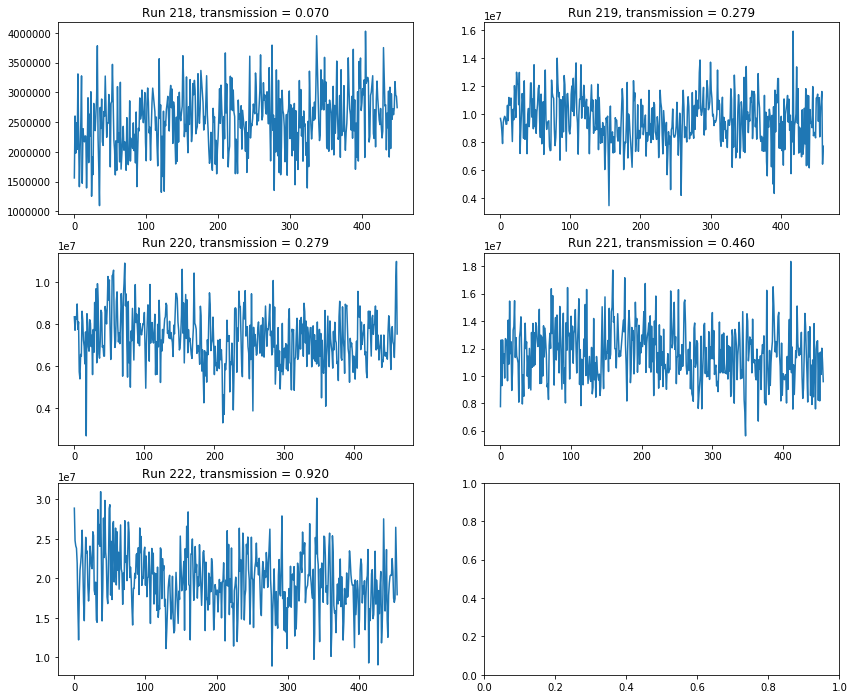

In [129]:
%matplotlib inline
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
for counter, key in enumerate(outpows):
    axes[counter // 2, counter % 2].plot(outpows[key])
    axes[counter // 2, counter % 2].set_title('Run {0:d}, transmission = {1:.3f}'.format(key, series[key]))
plt.show()

# Hot regions correction and wobble simulation

In [5]:
f295 = h5py.File(outpath.format(295, 0), 'r')
datalist295  = []
for key in f295['data/data']:
    datalist295.append(f295['data/data/' + key][:])
pids295 = np.arange(4, 309, 16)

In [199]:
offsetted_data = [np.where(data < 6500, data, data - 3000) for data in datalist295]
filtered_data = [np.array([median_filter(frame, 3) for frame in data]) for data in offsetted_data]
meandata = np.array([np.mean(data, axis=0) for data in filtered_data])[:, 7:-7, 7:-7]
meandata.shape

(20, 276, 296)

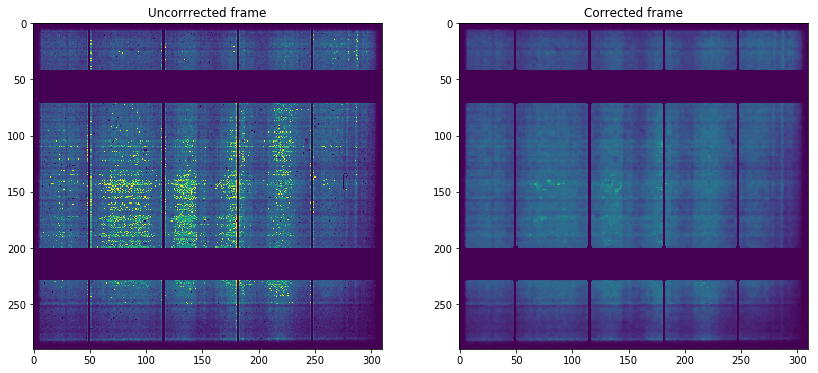

In [233]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(datalist295[0][10], vmin=0, vmax=15000)
axes[0].set_title('Uncorrrected frame')
axes[1].imshow(filtered_data[0][10], vmin=0, vmax=15000)
axes[1].set_title('Corrected frame')
plt.show()

In [164]:
scanfiles = {'W190305C_XS04': h5py.File('energyscans/MLL_250_energy_scan.h5', 'r'),
             'W190315C_XL03': h5py.File('energyscans/MLL_265_energy_scan_new.h5', 'r')}
rois = {'W190305C_XS04': (slice(None), slice(453, 665)),
        'W190315C_XL03': (slice(None), slice(210, 381))}
scans = dict([(key, scan['Data'][:]) for key, scan in scanfiles.items()])
omegas = dict([(key, scan['Omega'][:]*1e-9) for key, scan in scanfiles.items()])
thetas = dict([(key, scan['2Theta'][:]) for key, scan in scanfiles.items()])

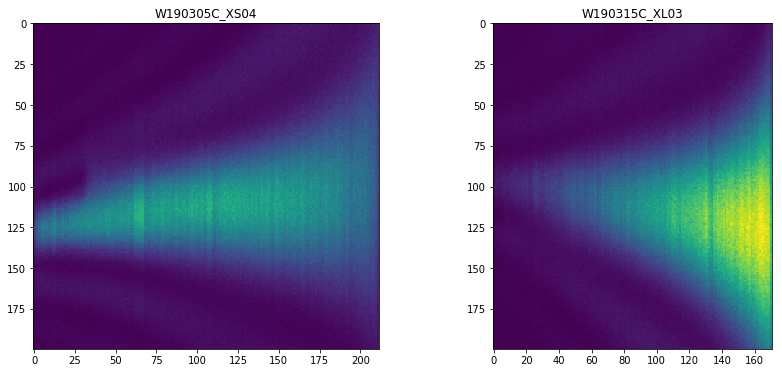

In [165]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for counter, lens in enumerate(scanfiles):
    axes[counter].imshow(scans[lens][rois[lens]], vmax=1000)
    axes[counter].set_title(lens)
plt.show()

In [166]:
for counter, lens in enumerate(scanfiles):
    th = thetas[lens][rois[lens][1]] / 180 * np.pi
    print('{}:'.format(lens))
    print('energy scan: {:.4f}'.format(th.max() - th.min()))
    print('speckle tracking: {:.4f}'.format(wavefronts[lens][:, 0].max() - wavefronts[lens][:, 0].min()))
    print('lens geometry: {:.4f}'.format(dthetas[counter]))
    print('AGIPD: {:.4f}'.format(dthetas2[counter]), end='\n\n')

W190305C_XS04:
energy scan: 0.0166
speckle tracking: 0.0149
lens geometry: 0.0090
AGIPD: 0.0138

W190315C_XL03:
energy scan: 0.0134
speckle tracking: 0.0079
lens geometry: 0.0102
AGIPD: 0.0148



In [244]:
hpupils = np.mean(meandata[:, :, :], axis=1)[:, ::-1]
vpupils = np.mean(meandata[:, :, :], axis=2)[:, ::-1]
hlens = 'W190305C_XS04'
hths = thetas[hlens][rois[hlens][1]][::-1]
newhths = np.linspace(hths.min(), hths.max(), hpupils.shape[1], endpoint=True)
hpupilcalc = np.array([np.interp(newhths, hths, envelope) for envelope in scans[hlens][rois[hlens]]])
vlens = 'W190315C_XL03'
vths = thetas[vlens][rois[vlens][1]]
newvths = np.linspace(vths.min(), vths.max(), vpupils.shape[1], endpoint=True)
vpupilcalc = np.array([np.interp(newvths, vths, envelope) for envelope in scans[vlens][rois[vlens]]])
print(hpupilcalc.shape, vpupilcalc.shape)

(200, 296) (200, 276)


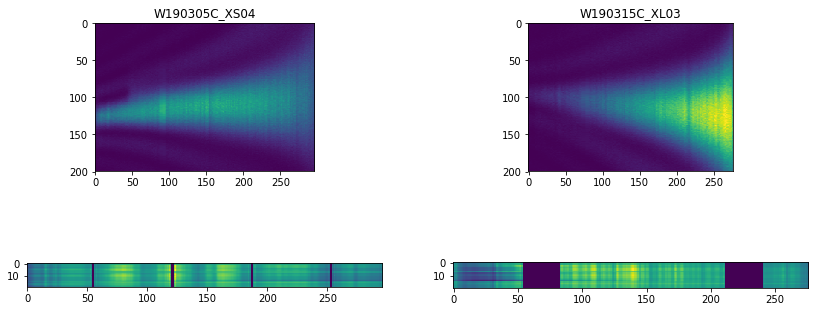

In [245]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
axes[0, 0].imshow(hpupilcalc, vmax=1000)
axes[0, 0].set_title(hlens)
axes[0, 1].imshow(vpupilcalc, vmax=1000)
axes[0, 1].set_title(vlens)
axes[1, 0].imshow(hpupils)
axes[1, 1].imshow(vpupils)
plt.show()

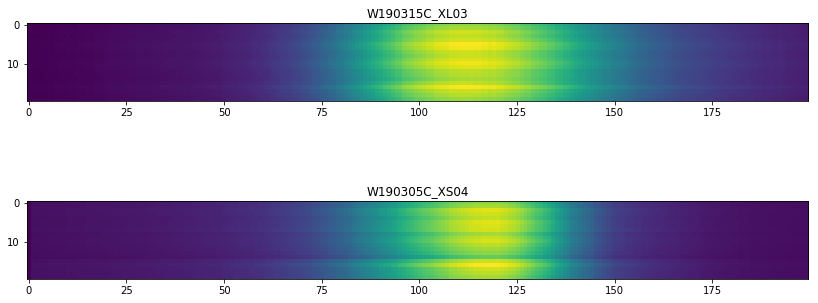

In [246]:
%matplotlib inline
hcor = np.dot(hpupils, hpupilcalc.T)
vcor = np.dot(vpupils, vpupilcalc.T)
fig, axes = plt.subplots(2, 1, figsize=(14, 6))
axes[0].imshow(vcor)
axes[0].set_title(vlens)
axes[1].imshow(hcor)
axes[1].set_title(hlens)
plt.show()

In [25]:
0.01 * 180 / np.pi

0.5729577951308232

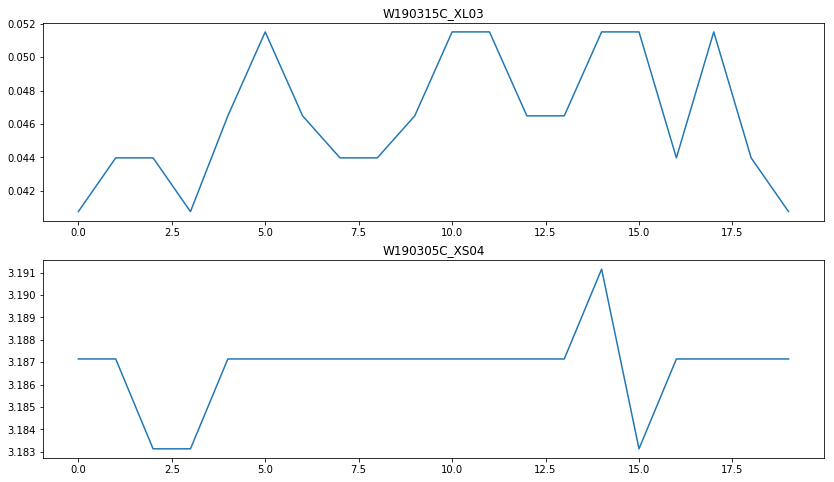

In [247]:
%matplotlib inline
homegas = np.array([omegas[hlens][arg] for arg in hcor.argmax(axis=1)])
vomegas = np.array([omegas[vlens][arg] for arg in vcor.argmax(axis=1)])
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
axes[0].plot(homegas)
axes[0].set_title(vlens)
axes[1].plot(vomegas)
axes[1].set_title(hlens)
plt.show()

In [224]:
pids295

array([  4,  20,  36,  52,  68,  84, 100, 116, 132, 148, 164, 180, 196,
       212, 228, 244, 260, 276, 292, 308])

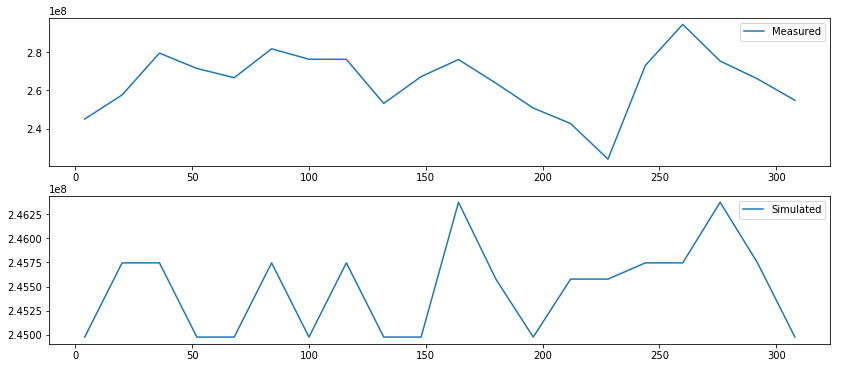

In [243]:
%matplotlib inline
hpupilsim = np.array([hpupilcalc[arg] for arg in hcor.argmax(axis=1)])
vpupilsim = np.array([vpupilcalc[arg] for arg in vcor.argmax(axis=1)])
powsim = hpupilsim.sum(axis=1) * vpupilsim.sum(axis=1)
fig, axes = plt.subplots(2, 1, figsize=(14, 6))
axes[0].plot(pids295, meandata.sum(axis=(1, 2)), label='Measured')
axes[0].legend()
axes[1].plot(pids295, powsim / powsim[0] * meandata.sum(axis=(1, 2))[0], label='Simulated')
axes[1].legend()
plt.show()

In [45]:
%%capture

from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow([[]], vmin=0, vmax=10000, cmap='viridis', extent=[-1, 1, -1 ,1])

In [99]:
def init():
    im.set_data([[]])
    return im,

def animate_mean(i):
    ax.set_title("Pulse ID = {:d}".format(int(pids295[i])))
    im.set_data(mean_data[i])
    return im,

anim_mean = animation.FuncAnimation(fig, animate_mean, init_func=init, interval=500, frames=20, blit=True)
# anim_mean.save('run_295.mp4', extra_args=['-vcodec', 'libx264'])
HTML(anim_mean.to_html5_video())

In [36]:
def animate_pid(pid):
    ax.set_title("Pulse ID = {:d}".format(pid))
    idx = pids_295.tolist().index(pid)
    def animate(i):
        im.set_data(filtered_data[idx][i])
        return im,
    return animate

anim_pid = animation.FuncAnimation(fig, animate_pid(pids_295[0]), init_func=init, interval=200, frames=filtered_data[0].shape[0], blit=True)
# anim_pid.save('run_295_pid_4.mp4', extra_args=['-vcodec', 'libx264'])
HTML(anim_pid.to_html5_video())